# Analyzing "Real" and "Fake" News Sources

Connor Dunlop

## Introduction

The debate of real vs fake news has been an issue for more than a century. However, within the past few years, this issue has really come to the forefront (A Brief History of Fake News: https://www.cits.ucsb.edu/fake-news/brief-history). Now, it seems like fake news is more prominent than ever. With all of this fake news out there, it can be hard to tell what sources you can trust. Given the amount of data available, I would like to do some analysis on what constitutes real vs fake news by looking at classified examples between the years 2015 and 2018. Through this project I hope to answer questions like, what terms are an indicator of fake news, what are the most prevalent terms in both real and fake news, how accurately can we classify fake news given the title and its text, and can we determine if news is fake or not based solely on its title?

### Libraries Used

- Pandas: Used to arrange data into dataframes
- Matplotlib and Seaborn: Used for various plots throughout the project
- Numpy: Used to create and manipulate arrays
- Regex: Used to cleanse the raw text data
- Datetime: Used for date formatting
- Collections: Used to create dictionaries with a starting default value
- Contractions: Used to expand contractions
- Wordcloud: Used to create various word cloud representations
- Scikit-learn: Used to modeling and scoring
- Scipy: Used for t testing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import datetime
from collections import defaultdict
import contractions
import nltk
import seaborn as sns
import wordcloud
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import scipy.stats as st
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')

### The Dataset Used

The dataset I am using includes over 40000 examples of fake and non fake news from the years 2015 to 2018, including their titles, article text, subject, and date posted. This data was retrieved from kaggle: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv

## Obtaining and Cleaning the Data

After downloading the relevant csv files from kaggle, the first step is to read each of the files into pandas dataframes for easier manipulation

In [2]:
fake = pd.read_csv('fake.csv')
true = pd.read_csv('true.csv')

In [3]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


To allow easier analysis down the line, both of the dataframes will be combined into a single dataframe using a new column to indicate whether each record is fake or not. The subject column is also dropped as it is not relevant for this specific project.

In [5]:
fake['fake'] = [True]*len(fake)
true['fake'] = [False]*len(true)
fake = fake.drop('subject', axis = 1)
true = true.drop('subject', axis = 1)
df = fake.append(true, ignore_index = True)
del fake
del true
df.head()

,title,text,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,"December 31, 2017",True
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,"December 31, 2017",True
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...","December 30, 2017",True
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...","December 29, 2017",True
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,"December 25, 2017",True


I will also reformat the date into datetime objects to allow easier manipulation, while removing a handful of records that have malformed data.

In [6]:
months1 = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months2 = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

count = 0
to_drop = []
for row in df.iterrows(): # There are a few garbage rows that just contain random information
    if re.search(r'http.*', row[1]['date']) is not None:
        to_drop.append(count)
    count += 1
to_drop.append(18933) # just another random garbage row
df = df.drop(to_drop)

count = 0
for x in months1: #Unifying the date formats
    df['date'] = df['date'].replace(r'(\d\d?)-'+x+r'-(\d\d)', months2[count]+r' \1, 20\2', regex=True) #dd-month-yy
    df['date'] = df['date'].replace(x+r'( .*)', months2[count]+r'\1', regex=True) # replace abbreviation to full name
    df['date'] = df['date'].replace('('+months2[count]+r' \d\d?, \d{4})\s+', r'\1', regex=True) # Trimming
    count += 1
df['date'] = pd.to_datetime(df.date, format = '%B %d, %Y') # Converting to datetime
df.head()

,title,text,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,2017-12-31,True
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,2017-12-31,True
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",2017-12-30,True
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",2017-12-29,True
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,2017-12-25,True


As there are no null values in the dataset, we are able to proceed with our analysis

In [7]:
df.isnull().sum()

title    0
text     0
date     0
fake     0
dtype: int64

### NLP Tasks

I would like to do some analysis dealing with the words in each of the titles and texts for real and fake news. In order to do this, I need to first start by tokenizing the data. I will be using the NLTK library in order to do this. If you would like to learn more about tokenization, specifically with nltk, you can visit this link: https://www.analyticsvidhya.com/blog/2019/07/how-get-started-nlp-6-unique-ways-perform-tokenization/.

First I need to do some basic preparation in order better tokenize the data, including removing extra whitespace, making sure that there are spaces inbetween sentences, removing links, and changing everything to lowercase.

In [8]:
df['text'] = df['text'].replace(r'https?:\/\/.*[\r\n]*', '', regex=True) # Removing links (Thanks to https://towardsdatascience.com/regex-essential-for-nlp-ee0336ef988d for providing this regex)
df['text'] = df['text'].replace(r'pic\.twitter.*[\r\n]*', '', regex=True)
df['text'] = df['text'].replace(r'( [A-Za-z0-9]+\.)([A-Z])', r'\1 \2', regex=True) # No space after sentence
df['title'] = df['title'].replace(r'( .*\.)([A-Z])', r'\1 \2', regex=True)
df['text'] = df['text'].replace(r'(\d{4})(.)', r'\1 \2', regex=True) # No space after date
df['title'] = df['title'].replace(r'(\d{4})(.)', r'\1 \2', regex=True)
df['text'] = df['text'].replace(r' +', r' ', regex=True) # Too many spaces
df['title'] = df['title'].replace(r' +', r' ', regex=True)
df['text'] = df['text'].replace('couldn t', "couldn't", regex=True) # Specific error I noticed
df['title'] = list(map(lambda x: x.lower(), df.title)) # Changing to lower
df['text'] = list(map(lambda x: x.lower(), df.text))

Now that we have done some initial cleansing, the next step is to expand contractions to make them more meaningful when the text is tokenized.

In [9]:
df['text'] = list(map(lambda x: contractions.fix(x), df['text']))
df['title'] = list(map(lambda x: contractions.fix(x), df['title']))

Now I tokenize the data into words for the exploratory analysis

In [10]:
tokenized_title = []
tokenized_text = []
for x in df['title']:
    tokenized_title.append(nltk.word_tokenize(x))
for x in df['text']:
    tokenized_text.append(nltk.word_tokenize(x))
df['title_tokens'] = tokenized_title
df['text_tokens'] = tokenized_text
del tokenized_title
del tokenized_text

Now that the data is tokenized, there are some tokens that are not useful in the analysis. Punctuation and stop words (list of stopwords: https://www.ranks.nl/stopwords) do not provide any useful information and can be safely removed. 

In [11]:
stopwords = set(nltk.corpus.stopwords.words('english'))
punctuation = string.punctuation + '’‘”“…'
def remove_unecessary(tokens):
    new_list = []
    for x in tokens:
        x = x.translate(str.maketrans('','',punctuation)) # removes punctuation
        if len(x) > 0 and x not in stopwords and not x == '–':
            new_list.append(x)
    return new_list
df['text_tokens'] = list(map(lambda x: remove_unecessary(x), df['text_tokens']))
df['title_tokens'] = list(map(lambda x: remove_unecessary(x), df['title_tokens']))
del stopwords
del punctuation

The final step before analyzing the word data is to do some lemmatization. Lemmatization essentially changes different forms of a word to their base root. For example, running, ran, runs, would all be converted to just run. By doing this, we will really be able to look at the occurences of unique words in the dataset. For more information on lemmatization, you can visit, https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html.

The lemmatizer in the NLTK library also requires a part of speech in order to properly lemmatize the words it is given. I will also be using NLTK part of speech tagging to match each token with its proper part of speech.

In [12]:
# Takes a long time to run, try to only run this once
title_pos = list(map(lambda x: nltk.pos_tag(x), df['title_tokens']))
text_pos = list(map(lambda x: nltk.pos_tag(x), df['text_tokens']))
df['text_pos'] = text_pos
df['title_pos'] = title_pos

With the part of speech, now we can do the lemmatization. The part of speech does have to be converted into the same format as the lemmatizer before being used, however

In [13]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def get_pos(pos):
    if pos[0] == 'J':
        return nltk.corpus.wordnet.ADJ
    elif pos[0] == 'R':
        return nltk.corpus.wordnet.ADV
    elif pos[0] == 'N':
        return nltk.corpus.wordnet.NOUN
    elif pos[0] == 'V':
        return nltk.corpus.wordnet.VERB
    else:
        return nltk.corpus.wordnet.NOUN

df['title_tokens'] = list(map(lambda x: list(map(lambda y: lemmatizer.lemmatize(y[0], pos = get_pos(y[1])), x)), title_pos))
df['text_tokens'] = list(map(lambda x: list(map(lambda y: lemmatizer.lemmatize(y[0], pos = get_pos(y[1])), x)), text_pos))
del text_pos
del title_pos
del lemmatizer

## Exploratory Analysis

### Word Count

#### Titles

To start my analysis, I want to first off look at the data as a whole. I want to look at how long (in words) the text and titles are to get a general idea of how the data looks. I will visualize this using histograms. 

Text(0, 0.5, 'Occurences')

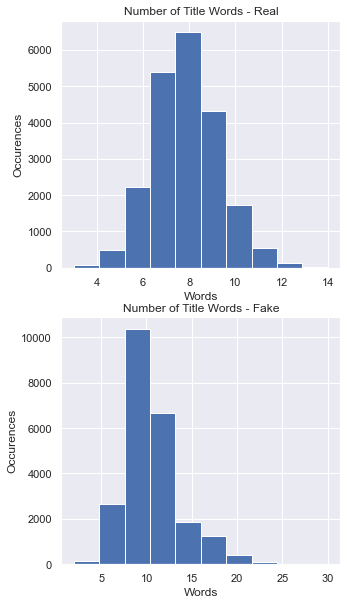

In [14]:
real = df[df.fake==False]
fake = df[df.fake==True]

sns.set(font_scale=1)
fig, ax = plt.subplots(nrows = 2, figsize=(5,10))
ax[0].hist(list(map(lambda x: len(x), real['title_tokens'])))
ax[0].set_title('Number of Title Words - Real')
ax[0].set_xlabel('Words')
ax[0].set_ylabel('Occurences')

ax[1].hist(list(map(lambda x: len(x), fake['title_tokens'])))
ax[1].set_title('Number of Title Words - Fake')
ax[1].set_xlabel('Words')
ax[1].set_ylabel('Occurences')

Looking at the title length, the majority of titles are between 6 and 12 words. The number of words ranges from 1 to 30 in fake news and 1 to 14 in real news. In general the title length distributions for real and fake news are fairly similar, however, the fake news titles seem slightly skewed to the left.

#### Text

Text(0, 0.5, 'Occurences')

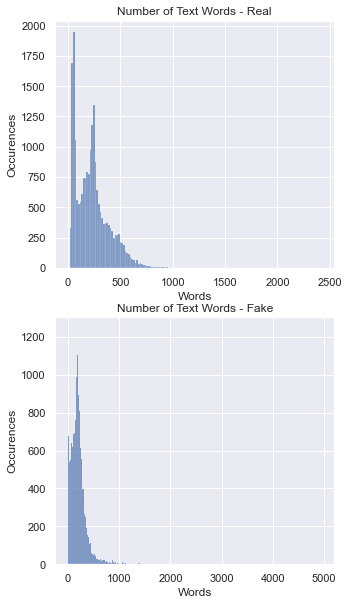

In [15]:
real = df[df.fake==False]
fake = df[df.fake==True]

sns.set(font_scale=1)
fig, ax = plt.subplots(nrows = 2, figsize=(5,10))
sns.histplot(list(map(lambda x: len(x), real['text_tokens'])),ax=ax[0])
ax[0].set_title('Number of Text Words - Real')
ax[0].set_xlabel('Words')
ax[0].set_ylabel('Occurences')

sns.histplot(list(map(lambda x: len(x), fake['text_tokens'])),ax=ax[1])
ax[1].set_title('Number of Text Words - Fake')
ax[1].set_xlabel('Words')
ax[1].set_ylabel('Occurences')

Looking at the plots for the text, it is hard to tell the general shape of the data due to some pretty large outliers. We can see that the number of words ranges from 1 to 5000 for fake news and 1 to 2500 for real news, however, its hard to tell beyond that any general trends. In order to visualize the data better, I will plot the histogram using only text that has under 800 words since the vast majority of data is below that number anyway.

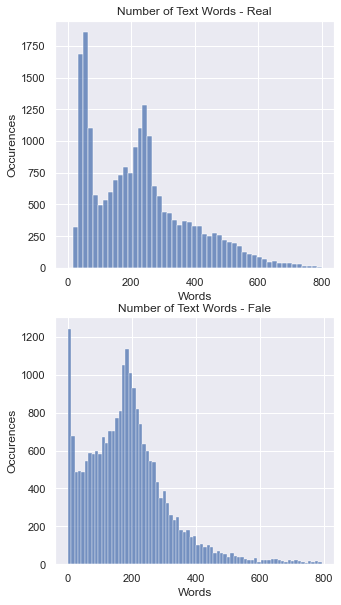

In [16]:
real = df[df.fake==False]
fake = df[df.fake==True]

sns.set(font_scale=1)
fig, ax = plt.subplots(nrows = 2, figsize=(5,10))

new_list_real = []
for x in list(map(lambda x: len(x), real['text_tokens'])):
    if x <= 800:
        new_list_real.append(x)
new_list_fake = []
for x in list(map(lambda x: len(x), fake['text_tokens'])):
    if x <= 800:
        new_list_fake.append(x)
        
sns.histplot(new_list_real,ax=ax[0])
ax[0].set_title('Number of Text Words - Real')
ax[0].set_xlabel('Words')
ax[0].set_ylabel('Occurences')

sns.histplot(new_list_fake,ax=ax[1])
ax[1].set_title('Number of Text Words - Fale')
ax[1].set_xlabel('Words')
ax[1].set_ylabel('Occurences')
del new_list_fake
del new_list_real

Now with this plot, we can see that most of the text is within roughly 0 to 300 words with a steep drop off after that. In general, it looks like fake news has a slightly higher percentage of lower word news articles when compared to real news, but the distributions are very similar.

### Dates

Next, I will look at the distribution of the number of news sources vs the date (per month) in order to get a sense of when fake vs news sources were most common between 2015 and 2018

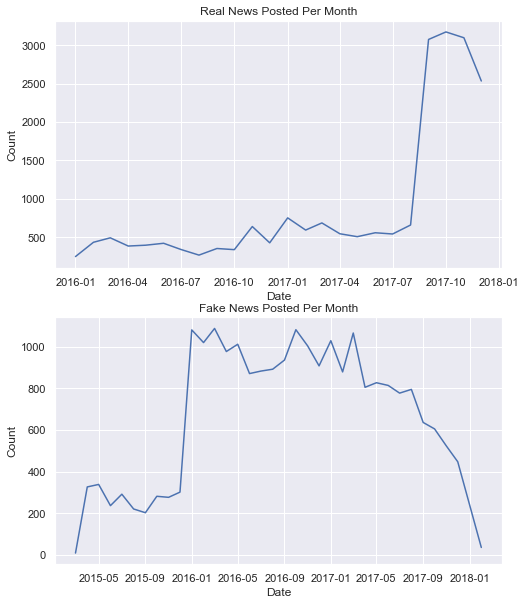

In [17]:
real = df[df.fake==False]
fake = df[df.fake==True]

dates_real = list(map(lambda x: datetime.date(x.year, x.month, 1), real['date'])) # Normalizing dates to the same day
dates_fake = list(map(lambda x: datetime.date(x.year, x.month, 1), fake['date']))

dates_real_count = defaultdict(int)
dates_fake_count = defaultdict(int)
for x in dates_real: # Counting dates
    dates_real_count[x] += 1
for x in dates_fake:
    dates_fake_count[x] += 1

sns.set(font_scale=1)
fig, ax = plt.subplots(nrows = 2, figsize=(8,10))
sns.lineplot(x=dates_real_count.keys(), y=dates_real_count.values(), ax = ax[0])
ax[0].set_title('Real News Posted Per Month')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Count')
sns.lineplot(x=dates_fake_count.keys(), y=dates_fake_count.values(), ax = ax[1])
ax[1].set_title('Fake News Posted Per Month')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Count')
del dates_real
del dates_fake
del dates_real_count
del dates_fake_count

Interestingly, there is actually a huge difference for the number of real and fake news articles being posted per month. Fake news has a pretty even date distribution for the number of articles, while real is very heavily skewed toward the late 2017s to early 2018s. Because the date for real news is skewed so heavily, I dont think that it is a product of real vs fake news, but instead a reasult of what resources the dataset creator chose to scrape. If this dataset were to get updated in the future, I would suggest choosing articles for both real and fake news from similar time periods. Because of this reason, I will not be using date to help determine whether an article is real or fake in my later machine learning analysis as it would not give a fair representation of the difference between the two types.

### Parts of Speech

Given the part of speech tagging done earlier, I would also like to analyse the amount of each part of speech within the text data

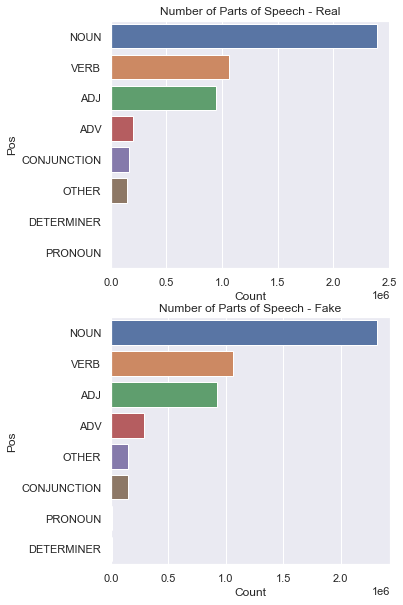

In [18]:
def get_pos(pos):
    if pos[0] == 'J':
        return 'ADJ'
    elif pos[0] == 'R':
        return 'ADV'
    elif pos[0] == 'N':
        return 'NOUN'
    elif pos[0] == 'V':
        return 'VERB'
    elif pos[0] == 'C':
        return 'CONJUNCTION'
    elif pos[0] == 'D':
        return 'DETERMINER'
    elif pos[0] == 'P':
        return 'PRONOUN'
    else:
        return 'OTHER'
real = df[df.fake==False]
fake = df[df.fake==True]

num_pos_real = defaultdict(int)
for y in real.text_pos:
    for x in y:
        num_pos_real[get_pos(x[1])] += 1
num_pos_real = dict(sorted(num_pos_real.items(), key=lambda x: x[1], reverse=True))
num_pos_fake = defaultdict(int)
for y in fake.text_pos:
    for x in y:
        num_pos_fake[get_pos(x[1])] += 1
num_pos_fake = dict(sorted(num_pos_fake.items(), key=lambda x: x[1], reverse=True))

sns.set(font_scale=1)
fig, ax = plt.subplots(nrows = 2, figsize=(5,10))
sns.barplot(x=list(num_pos_real.values()), y=list(num_pos_real.keys()), ax=ax[0])
sns.barplot(x=list(num_pos_fake.values()), y=list(num_pos_fake.keys()), ax=ax[1])
ax[0].set_title('Number of Parts of Speech - Real')
ax[1].set_title('Number of Parts of Speech - Fake')
ax[0].set_xlabel('Count')
ax[1].set_xlabel('Count')
ax[0].set_ylabel('Pos')
ax[1].set_ylabel('Pos')
del num_pos_real
del num_pos_fake
df = df.drop('title_pos', axis = 1)
df = df.drop('text_pos', axis = 1)

Through this chart, nouns are the most common by far, while verbs and adverbs are pretty close at second and third, and every other part of speech is much less frequent. Unsurprisingly, both fake and real news have nearly identical parts of speech distributions.

### Wordclouds

I now want to do some more detailed analysis by looking at what terms are more frequent in fake news vs real news. To do this, I start off by making dictionaries to count the occurences of each word in the tokenized dataset for both titles and text. These dictionaries are then sorted in descending order.

In [19]:
real = df[df['fake'] == False]
fake = df[df['fake'] == True]
top_title_real = defaultdict(int)
top_text_real = defaultdict(int)
top_title_fake = defaultdict(int)
top_text_fake = defaultdict(int)
for x in real['title_tokens']:
    for word in x:
        top_title_real[word] += 1
for x in real['text_tokens']:
    for word in x:
        top_text_real[word] += 1
for x in fake['title_tokens']:
    for word in x:
        top_title_fake[word] += 1
for x in fake['text_tokens']:
    for word in x:
        top_text_fake[word] += 1
        
top_text_fake = dict(sorted(top_text_fake.items(), key=lambda x: x[1], reverse=True))#sorts a dictionary in descending order
top_text_real = dict(sorted(top_text_real.items(), key=lambda x: x[1], reverse=True))
top_title_fake = dict(sorted(top_title_fake.items(), key=lambda x: x[1], reverse=True))
top_title_real = dict(sorted(top_title_real.items(), key=lambda x: x[1], reverse=True))

The above dictionaries are now used to make wordclouds to represent the frequency of words in titles and text bodies for both real and fake news.

#### Real Titles

WORDCLOUD - REAL TITLES


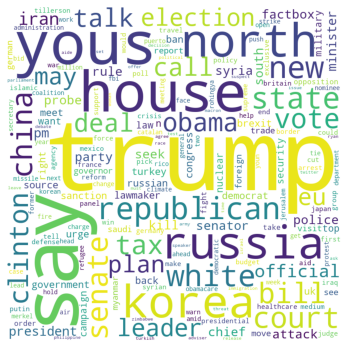

In [20]:
title_real = wordcloud.WordCloud(width = 750, height = 750,
                background_color ='white',
                stopwords = wordcloud.STOPWORDS,
                min_font_size = 10).generate_from_frequencies(top_title_real)
plt.figure(figsize = (6, 10))
plt.axis("off")
plt.imshow(title_real)
print("WORDCLOUD - REAL TITLES")

#### Fake Titles

WORDCLOUD - FAKE TITLES


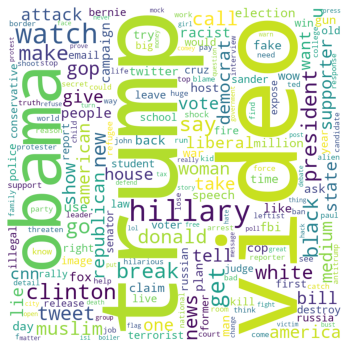

In [21]:
title_fake = wordcloud.WordCloud(width = 750, height = 750,
                background_color ='white',
                stopwords = wordcloud.STOPWORDS,
                min_font_size = 10).generate_from_frequencies(top_title_fake)
plt.figure(figsize = (6, 10))
plt.axis("off")
plt.imshow(title_fake)
print("WORDCLOUD - FAKE TITLES")

#### Real Text

WORDCLOUD - REAL TEXT


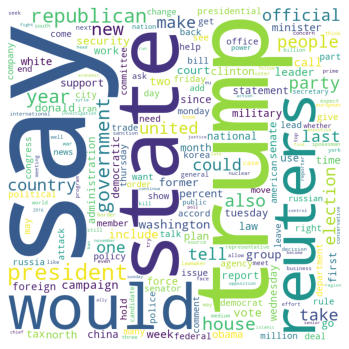

In [22]:
text_real = wordcloud.WordCloud(width = 750, height = 750,
                background_color ='white',
                stopwords = wordcloud.STOPWORDS,
                min_font_size = 10).generate_from_frequencies(top_text_real)
plt.figure(figsize = (6, 10))
plt.axis("off")
plt.imshow(text_real)
print("WORDCLOUD - REAL TEXT")

#### Fake Text

WORDCLOUD - FAKE TEXT


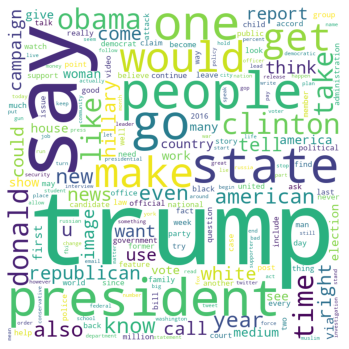

In [23]:
text_fake = wordcloud.WordCloud(width = 750, height = 750,
                background_color ='white',
                stopwords = wordcloud.STOPWORDS,
                min_font_size = 10).generate_from_frequencies(top_text_fake)
plt.figure(figsize = (6, 10))
plt.axis("off")
plt.imshow(text_fake)
print("WORDCLOUD - FAKE TEXT")

In all four word clouds, the first or second most frequent word is trump. This is most likely a result of the time period that the data was scraped, and the fact that most of the news data is realating to politics.

First, I want to take a look at the differences between real and fake titles. Fake titles much more frequentlty use the words, hillary and obama which was interesting to me. Maybe fake news tends to write more articles about these two figures. The word video was also much more frequent, being the second most frequent word in fake news, whereas in real news, it is not even visible. Real news tends to talk about locations more, such as Russia, North Korea, Iran, and China.

In terms of the text data, it actually appear pretty similar on a surface level. One main difference is that a major word in real news, which is not present in fake news at all is reuters, which makes sense as they are a news source known for generally giving unbiased, accurate news. Another standout to me was the fact that the word people was much more common in fake news. Maybe fake news uses the term to generalize more.

In [24]:
# Cleaning up some old variables to avoid running out of memory
del top_text_real
del top_text_fake
del top_title_real
del top_title_fake
del text_real
del text_fake
del title_real
del title_fake

### ngrams

The last basic analysis I would like to do on this dataset before moving onto modeling is to look at some of the ngram frequencies in order to see if certain combinations of words a more frequent in real vs fake news. Hopefully this will make differences between the two more clear. To learn more about n-grams and their importance in natural language processing you can visit, https://www.seerinteractive.com/blog/what-are-ngrams-and-uses-case/.

Here, the ngrams are being created add counted/sorted in dictionaries in order to plot them later. This is done using a provided method from nltk

In [25]:
df['title_2gram'] = list(map(lambda x: list(nltk.ngrams(x,2)), df['title_tokens']))
df['title_3gram'] = list(map(lambda x: list(nltk.ngrams(x,3)), df['title_tokens']))
df['title_4gram'] = list(map(lambda x: list(nltk.ngrams(x,4)), df['title_tokens']))
df['text_2gram'] = list(map(lambda x: list(nltk.ngrams(x,2)), df['text_tokens']))
df['text_3gram'] = list(map(lambda x: list(nltk.ngrams(x,3)), df['text_tokens']))
df['text_4gram'] = list(map(lambda x: list(nltk.ngrams(x,4)), df['text_tokens']))

real = df[df['fake'] == False]
fake = df[df['fake'] == True]
def count_and_sort(arr):
    dic = defaultdict(int)
    for x in arr:
        for gram in x:
            gram = ' '.join(gram)
            dic[gram] += 1
    return dict(sorted(dic.items(), key=lambda x: x[1], reverse=True))

title_real_2 = count_and_sort(real['title_2gram'])
title_real_3 = count_and_sort(real['title_3gram'])
title_real_4 = count_and_sort(real['title_4gram'])
title_fake_2 = count_and_sort(fake['title_2gram'])
title_fake_3 = count_and_sort(fake['title_3gram'])
title_fake_4 = count_and_sort(fake['title_4gram'])
text_real_2 = count_and_sort(real['text_2gram'])
text_real_3 = count_and_sort(real['text_3gram'])
text_real_4 = count_and_sort(real['text_4gram'])
text_fake_2 = count_and_sort(fake['text_2gram'])
text_fake_3 = count_and_sort(fake['text_3gram'])
text_fake_4 = count_and_sort(fake['text_4gram'])

#### Titles

Here is the code to create the plots for each title ngram

Text(0.5, 1.0, 'Title 4grams - Fake')

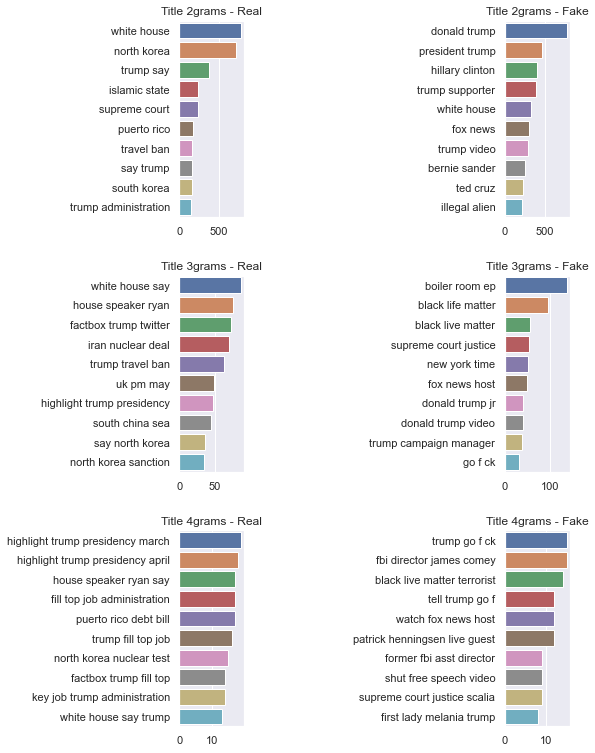

In [26]:
TOP_X = 10

sns.set(font_scale=1)
fig, ax = plt.subplots(nrows = 3, ncols=2, figsize=(7,10))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.3, wspace=4)
sns.barplot(x=list(title_real_2.values())[:TOP_X],y=list(title_real_2.keys())[:TOP_X],ax=ax[0][0])
sns.barplot(x=list(title_real_3.values())[:TOP_X],y=list(title_real_3.keys())[:TOP_X],ax=ax[1][0])
sns.barplot(x=list(title_real_4.values())[:TOP_X],y=list(title_real_4.keys())[:TOP_X],ax=ax[2][0])
ax[0][0].set_title('Title 2grams - Real')
ax[1][0].set_title('Title 3grams - Real')
ax[2][0].set_title('Title 4grams - Real')

sns.barplot(x=list(title_fake_2.values())[:TOP_X],y=list(title_fake_2.keys())[:TOP_X],ax=ax[0][1])
sns.barplot(x=list(title_fake_3.values())[:TOP_X],y=list(title_fake_3.keys())[:TOP_X],ax=ax[1][1])
sns.barplot(x=list(title_fake_4.values())[:TOP_X],y=list(title_fake_4.keys())[:TOP_X],ax=ax[2][1])
ax[0][1].set_title('Title 2grams - Fake')
ax[1][1].set_title('Title 3grams - Fake')
ax[2][1].set_title('Title 4grams - Fake')

By looking at 2, 3, and 4 grams for real vs fake news titles, it becomes a lot clearer what sets of words go together and why individual words were more common. It paints a better picture of what types of things can cause an article to be real or fake. For example, in fake news talk about people such as Ted Cruz, Hilary Clinton, and Bernie Sanders are more common. There is also talk about the Black Lives Matter movement, fox news, illegal aliens, fbi directors, and expletives directed at Trump. Real news tends to focus on more formal news such as North Korea, the White House, the Supreme Court, and the House Speaker.

#### Text

Here is the code to create the plots for each text ngram

Text(0.5, 1.0, 'Text 4grams - Fake')

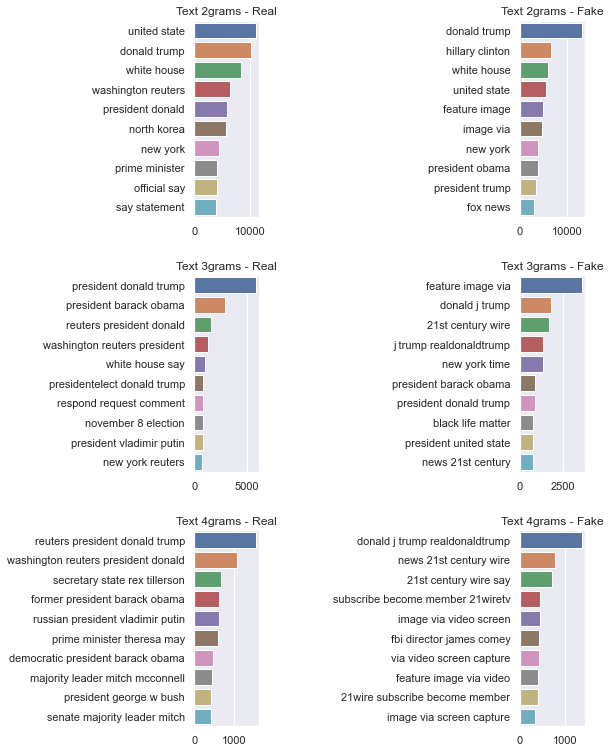

In [27]:
TOP_X = 10

sns.set(font_scale=1)
fig, ax = plt.subplots(nrows = 3, ncols=2, figsize=(7,10))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.3, wspace=4)
sns.barplot(x=list(text_real_2.values())[:TOP_X],y=list(text_real_2.keys())[:TOP_X],ax=ax[0][0])
sns.barplot(x=list(text_real_3.values())[:TOP_X],y=list(text_real_3.keys())[:TOP_X],ax=ax[1][0])
sns.barplot(x=list(text_real_4.values())[:TOP_X],y=list(text_real_4.keys())[:TOP_X],ax=ax[2][0])
ax[0][0].set_title('Text 2grams - Real')
ax[1][0].set_title('Text 3grams - Real')
ax[2][0].set_title('Text 4grams - Real')

sns.barplot(x=list(text_fake_2.values())[:TOP_X],y=list(text_fake_2.keys())[:TOP_X],ax=ax[0][1])
sns.barplot(x=list(text_fake_3.values())[:TOP_X],y=list(text_fake_3.keys())[:TOP_X],ax=ax[1][1])
sns.barplot(x=list(text_fake_4.values())[:TOP_X],y=list(text_fake_4.keys())[:TOP_X],ax=ax[2][1])
ax[0][1].set_title('Text 2grams - Fake')
ax[1][1].set_title('Text 3grams - Fake')
ax[2][1].set_title('Text 4grams - Fake')

Looking at the 2, 3, and 4 grams for the news text also gives us some more insight on what defines real vs fake news. Based on the text that contains image, video, realdonald trump, etc, we can conclude that a lot of the fake news comes from social media, most likely twitter. A lot of the fake news is also coming from news 21st century wire. Fake news has similar top ngrams to the fake titles above. Similar to the above as well, real news talks about more formal news topics such as the white house, vladimir putin, and the prime minister.

In [28]:
# Cleaning up some old variables to avoid running out of memory
del title_real_2
del title_real_3
del title_real_4
del title_fake_2
del title_fake_3
del title_fake_4
del text_real_2
del text_real_3
del text_real_4
del text_fake_2
del text_fake_3
del text_fake_4
df = df.drop('title_3gram', axis = 1) # These are no longer necessary, explained under modeling section
df = df.drop('text_3gram', axis = 1)
df = df.drop('title_4gram', axis = 1)
df = df.drop('text_4gram', axis = 1)

## Modeling

According to https://monkeylearn.com/text-classification/, there are two types of machine learning techniques that are commonly used to classify text data: Naive Bayes (specifically multinomial naive bayes) and support vector machines. In theory, support vector machines are better on average at modeling text data, however, for the sake of this tutorial, naive bayes will be used as it is significantly faster at creating models. In this project, I want to see how accurately models can predict fake vs real news by only using the title vs using the news text body.

### Feature Extraction

In order to run machine learning models on the data, I first must use feature extraction to transform the data into something that can be modeled. I will use the bag of words technique to do this. More specifically, I will be using the TF-IDF method (Term Frequency - Inverse Document Frequency) to make sure to reflect the importance of words in the documents. To learn in more detail how TF-IDF works you can visit, https://monkeylearn.com/blog/what-is-tf-idf/. Based on the above analysis, I believe a bigram approach to TF-IDF would be the best as some of the words alone do not make sense using simply a unigram model.

In [29]:
def bool_to_int(x):
    if x:
        return 1
    return 0

model = TfidfVectorizer(ngram_range=(2,2))
title_sentences = list(map(lambda x: ' '.join(x), df['title_tokens']))
text_sentences = list(map(lambda x: ' '.join(x), df['text_tokens']))

title_training = model.fit_transform(title_sentences) # These must be left as sparse matrices to still be able to work within ram
text_training = model.fit_transform(text_sentences)
targets = np.array(list(map(lambda x: bool_to_int(x), df['fake'])))
del title_sentences
del text_sentences

### F-Score

The accuracy of the model will be measured using f score in order to base the model's accuracy off of both precision and recall. Precision is the measure of true positive results over the positive results returned and recall is the number of true positive results over all of the possible positive results. F score is essentially just a number that combines these two values.

In [30]:
def fscore(clf, x, y):
    predictions = clf.predict(x)
    
    correct_pos = 0
    i = 0
    for x in predictions:
        if x == 1 and y[i] == x:
            correct_pos += 1
        i += 1        
    returned_pos = np.count_nonzero(predictions == 1)    
    possible_pos = np.count_nonzero(y == 1)
    
    precision = correct_pos/returned_pos
    recall = correct_pos/possible_pos
    
    return 2*((precision*recall)/(precision+recall))

### Title Bayes Model

In order to test the accuracy of the models, 10-fold cross validation will be used, which essentially splits the data into 10 random groups and uses each group as a hold out for the set to get a more accurate performance measure. Modeling for the title will be looked at first. This link gives a more detailed explanation of cross fold validation: https://machinelearningmastery.com/k-fold-cross-validation/

In [31]:
clf = MultinomialNB()
scores_title = np.array(cross_val_score(clf, title_training, targets, cv=10, scoring = fscore))

print("Bayes Title Mean 10-Fold Score:",np.mean(scores_title))
print("Bayes Title Standard 10-Fold Error:",st.sem(scores_title))

Bayes Title Mean 10-Fold Score: 0.8887477406455613
Bayes Title Standard 10-Fold Error: 0.019834565687625774


### Text Bayes Model

In [32]:
clf = MultinomialNB()
scores_text = np.array(cross_val_score(clf, text_training, targets, cv=10, scoring = fscore))

print("Bayes Text Mean 10-Fold Score:",np.mean(scores_text))
print("Bayes Text Standard 10-Fold Error:",st.sem(scores_text))

Bayes Text Mean 10-Fold Score: 0.9491452337008252
Bayes Text Standard 10-Fold Error: 0.01014057961329774


As expected, the model performs much better on the text data, simply because there is just a lot more data to model. I was still suprised however, that by solely using the title and a very simple model, I was able to get nearly a 90% accuracy on predicting whether a news source is real or fake. In order to further support the claim that modeling based on the text vs the title data is much more accurate, I will perform a paired t-test (What is a paired T-test?: https://www.jmp.com/en_us/statistics-knowledge-portal/t-test/paired-t-test.html).

### Paired T Test

Null Hypothesis: The difference between the true average scores of the title and text models is zero.

Alternate Hypothesis: The true mean difference between the true average scores of the title and text models is less than zero (making the text model have a higher score)

In [33]:
statistic, pvalue = st.ttest_rel(scores_title,scores_text)

In [34]:
#We will let the level of significiance be 1%
alpha = .01
if pvalue < alpha:
    print("Reject the null hypothesis")
else:
    print("Do not reject the null hypothesis")

Reject the null hypothesis


Based on the sample data, we have sufficient evidence to conclude that the difference between the two true average scores above is less than zero using 1% level of significance, which implies that the text based bayes model is better on average.

### Text K Nearest Neighbor Model

In order to further prove that naive bayes is a good fit for the data (and slightly just because I wanted to train a KNN model), I will use another commonly used machine learning model, K Nearest Neighbors and show its accuracy.

In [35]:
clf = KNeighborsClassifier()
scores_text_k = np.array(cross_val_score(clf, text_training, targets, cv=10, scoring = fscore))

print("K Means Text Mean 10-Fold Score:",np.mean(scores_text_k))
print("K Means Text Standard 10-Fold Error:",st.sem(scores_text_k))

K Means Text Mean 10-Fold Score: 0.6868315325440404
K Means Text Standard 10-Fold Error: 0.00010082467650882041


Based on the above accuracy, Naive Bayes is definitely the clear winner. Due to the large difference between the two values and very low standard errors, a paired t test is not necessary to prove this.

### Hyper Parameter Tuning

Since Naive Bayes only really has one hyper parameter (Learn more about hyperparameters: https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/) to tune, the alpha smoothing, and it is relatively quick to run, I will use an exhaustive approach to determine the best parameter using 10 fold cross validation.

In [36]:
grid = {'alpha': np.linspace(0,1,100)}
clf = MultinomialNB()
model = GridSearchCV(estimator=clf, param_grid=grid, scoring=fscore, 
                     n_jobs=-1, cv=10, verbose=2)
model.fit(text_training, targets)
print("Best Alpha:",model.best_params_['alpha'])
print("Best Score:",model.best_score_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Alpha: 0.07070707070707072
Best Score: 0.9532615231757401


After tunning the parameters, I found that an alpha of .07 leads to an f score of 95.3%, which is better than the previous f score found without any tuning. This means that using the naive bayes approach to modeling the dataset, Fake vs Real news can be predicted at 95.3% accuracy

## Conclusion

### Summary

In this tutorial, the goal was to determine what aspects define both real and fake news, and how accurately the difference between them can be modeled. From the initial exploratory analysis, I learned basic statistics about the real vs fake news data provided, like typical word counts for each, parts of speech present, and the dates of when the news was posted. I also learned common words and phrases that are present in real vs fake news. For example fox new and hillary in fake news and reuters and north korea in real news. Finally, I compared the performance of naive bayes using both the title and text bodies, coming to the conclusing that training based on the text data resulted in a more accurate model. I then gave a counter example to naive bayes, to show that while support vector machines may be a slightly better (but a much, much, much slower) model, naive bayes does do a great job of representing the data in comparison to other models. I then further tuned the hyper parameters of the bayes model to get a 95.3% accuracy at predicting fake vs real news.

### Insight and Policy Decisions

Based on the accuracy of the model, I think that machine learning should be used more in picking out fake vs real news sources. With the accuracy that I was able to obtain using simply just a baye's model, I think even better models could be created to get an even higher accuracy. With the amount of fake news out there, more machine learning models could help keep the public aware of what they are reading. At the very least, the basic analysis done on this data can give people some basic terms and phrases to look out for when reading their news. 

### Future Work

One of the big things that I think could be done to greatly improve the analysis of fake vs real news in the future would be to collect more data from a wider variety of news sources and from a wider range of dates. This project proves the concept that a machine learning model can be effective in determining the difference between real and fake news, however, I feel like a lot of the news is specific to the 2016-2018 era which was very specific to the controversial Trump Presidency. This makes me wonder how well it would hold up against today's news. I think with more up to date data, some better optimization to be able to use the support vector machine, and some better tuning on some of the nlp tasks, a very accurate analysis of this topic could be done that would hold up to today's news.